# Violinplot over antal dage i cirkulation

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


In [2]:
# Find alle Excel-filer i en mappe
filer = glob.glob("/Users/mathias/Desktop/Uni/4. Semester/Dataprojekt/Rådata/2023 AAR vaskeri data/PLC*.xlsx")

# Indlæs alle filer og saml dem i en liste
dataframes = [pd.read_excel(fil, skiprows=2) for fil in filer]

# Eventuelt kombiner alle til én DataFrame
samlet_df = pd.concat(dataframes, ignore_index=True)

In [3]:
print(samlet_df.head())

                     Produkt - Produkt       Kassationsårsag (ui)  \
0             04290 Skjorte Marine P/B  Misligholdt med restværdi   
1         01085 T-Shirt Gråmelange p/b    Alm.slid uden restværdi   
2    07963 Busseron 1/Indv L/Æ Hvid Pb    Alm.slid uden restværdi   
3  02788 Sweatshirt Mblå Elis Chauffør               Udgået Model   
4  02788 Sweatshirt Mblå Elis Chauffør               Udgået Model   

   Stk. tøj per kassationsdato  Dage i cirkulation  Total antal vask  \
0                            1                6765               118   
1                            1                6303                58   
2                            1                5753                71   
3                            1                5719                 0   
4                            1                5719                34   

  Unik Kode (ui)  
0   00D003F3D627  
1   00D005120D02  
2   00D00588E66D  
3   00D006ABCB5D  
4   00D006ADF27E  


# Livstids plots

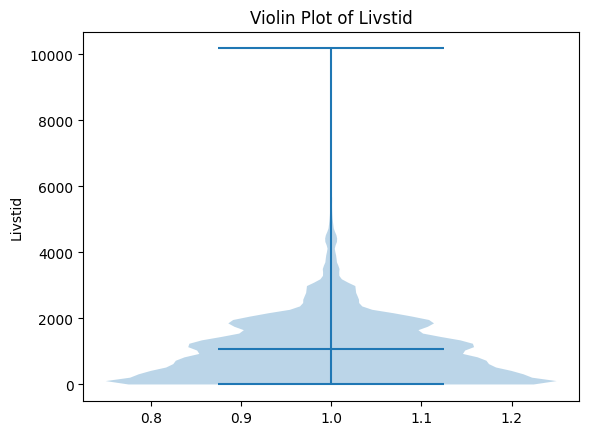

In [4]:
# Lav et violin plot af livstid
livstid = samlet_df['Dage i cirkulation']
plt.violinplot(livstid, showmeans=True)
plt.title('Violin Plot of Livstid')
plt.ylabel('Livstid')
plt.show()


## Opdeling i produktgruppe

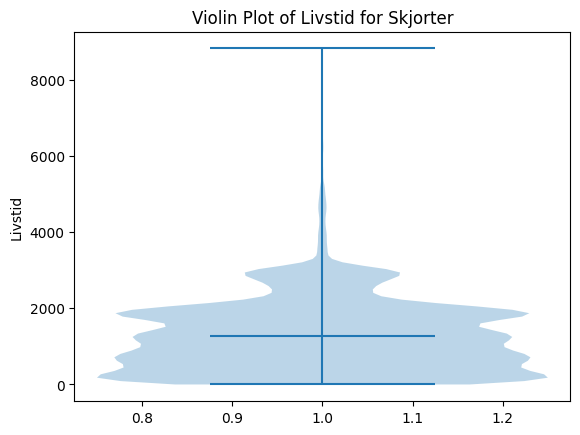

In [5]:
# Find alle tildfælde hvor skjorte indgår i produktnavnet
skjorte_data = samlet_df[samlet_df['Produkt - Produkt'].str.contains('skjorte', case=False, na=False)]

livstid = skjorte_data['Dage i cirkulation']
plt.violinplot(livstid, showmeans=True)
plt.title('Violin Plot of Livstid for Skjorter')
plt.ylabel('Livstid')
plt.show()

## Opdeling af gruppe og kasseringsårsag

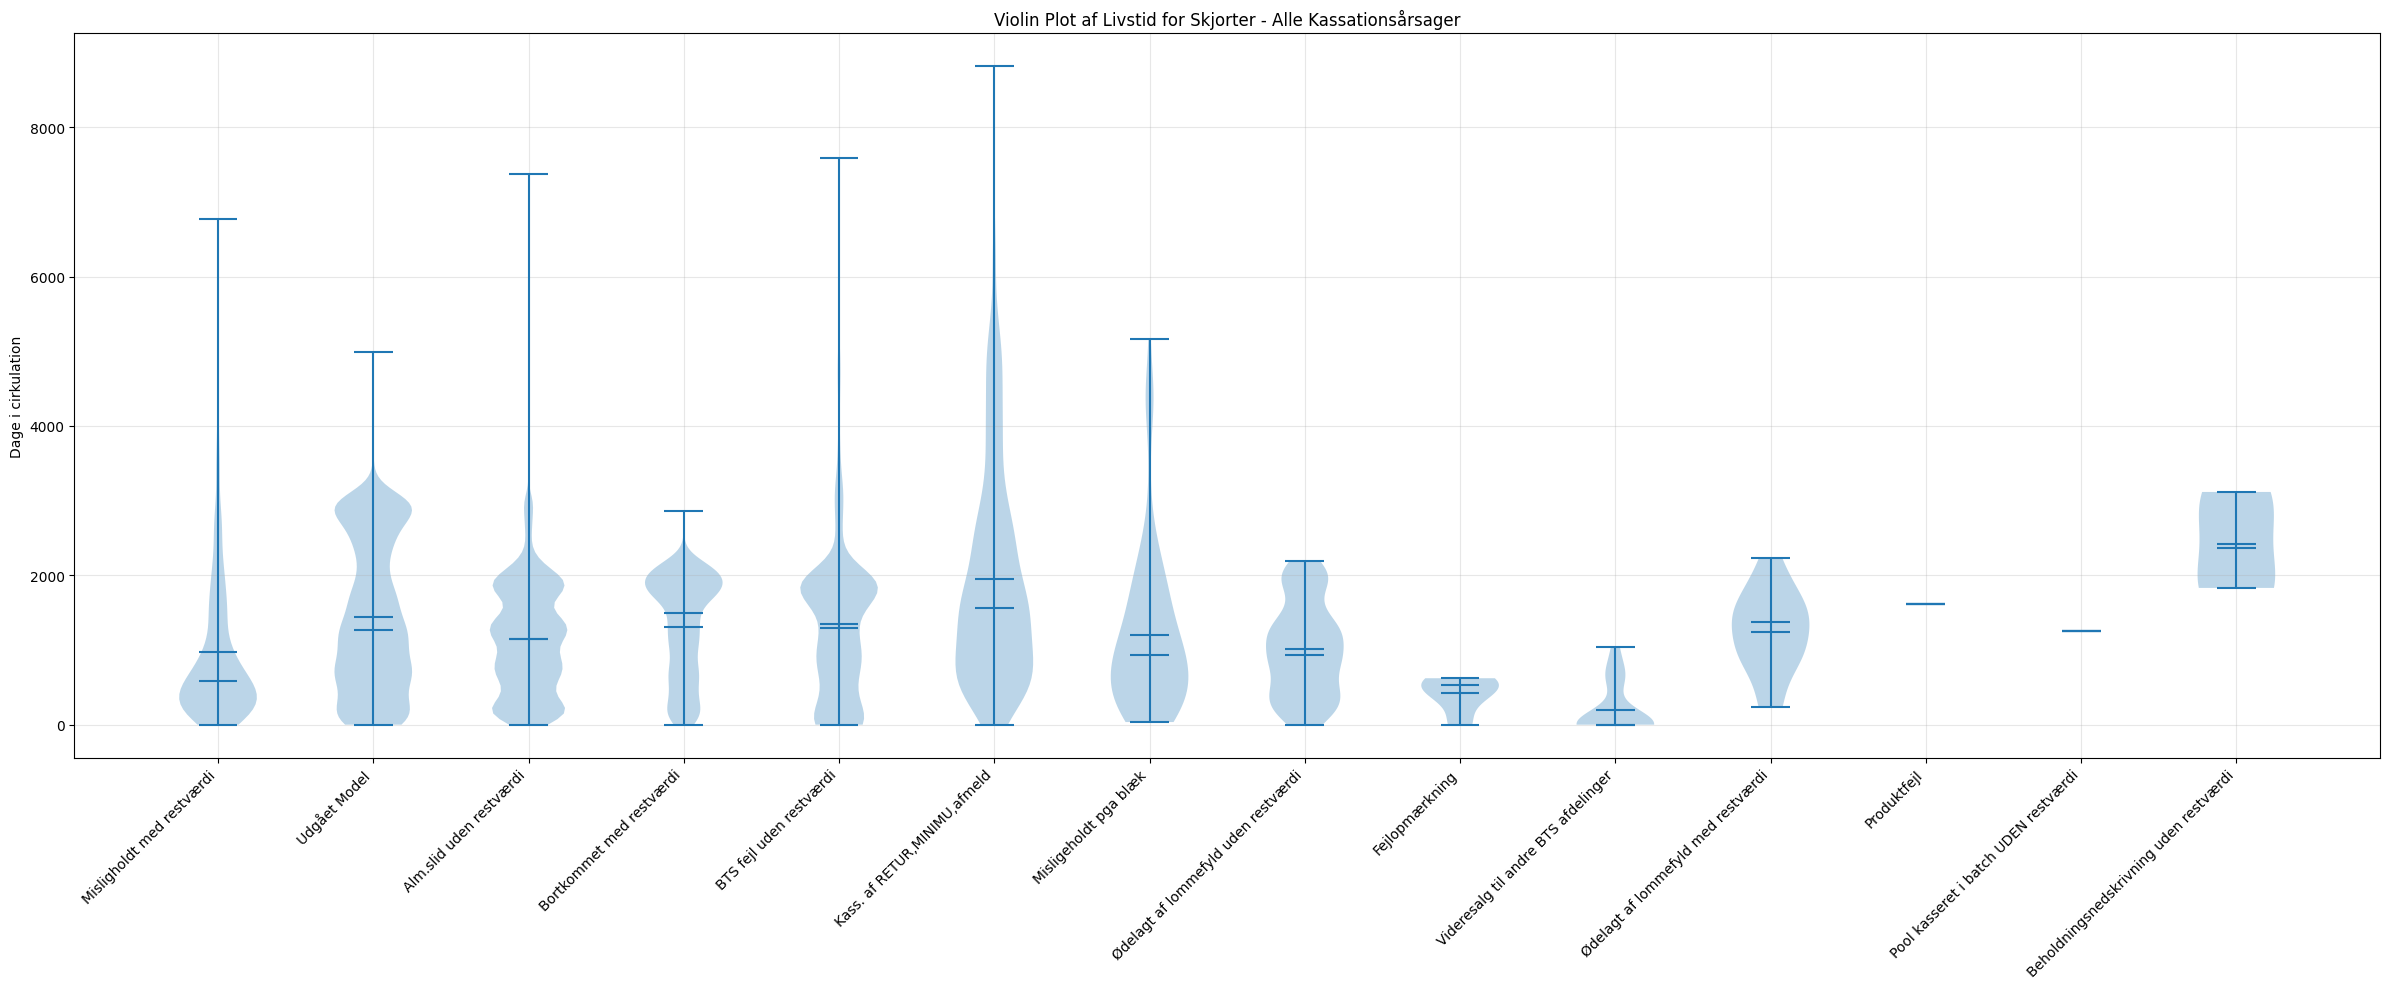

In [6]:
# Lav violin plot for hver kassationsårsag for skjorter i én figur
kassationsårsager = skjorte_data['Kassationsårsag (ui)'].unique()

# Forbered data for alle årsager
data_list = []
labels = []
for årsag in kassationsårsager:
    data = skjorte_data[skjorte_data['Kassationsårsag (ui)'] == årsag]['Dage i cirkulation']
    if len(data) > 0:  # Kun inkluder hvis der er data
        data_list.append(data)
        labels.append(årsag)

# Opret figur
fig, ax = plt.subplots(figsize=(24, 10))

# Lav violin plots
parts = ax.violinplot(data_list, showmeans=True, showmedians=True)

# Tilpas udseende
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Dage i cirkulation')
ax.set_title('Violin Plot af Livstid for Skjorter - Alle Kassationsårsager')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


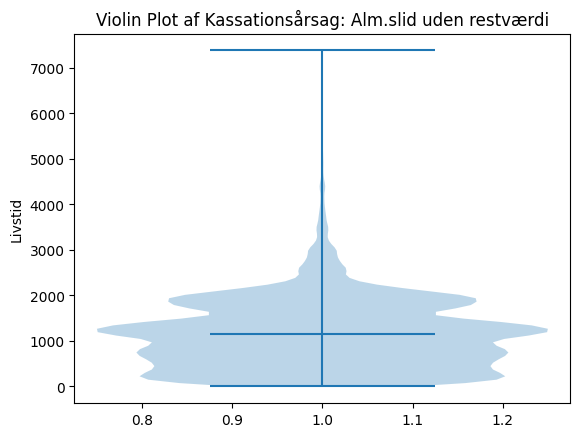

In [24]:
# Lav et violin plot af livstid

kassationsårsag = "Alm.slid uden restværdi"

livstid = samlet_df[samlet_df['Kassationsårsag (ui)'] == kassationsårsag]['Dage i cirkulation']
plt.violinplot(livstid, showmeans=True)
plt.title(f'Violin Plot af Kassationsårsag: {kassationsårsag}')
plt.ylabel('Livstid')
plt.show()

# Antal Vaske Plots

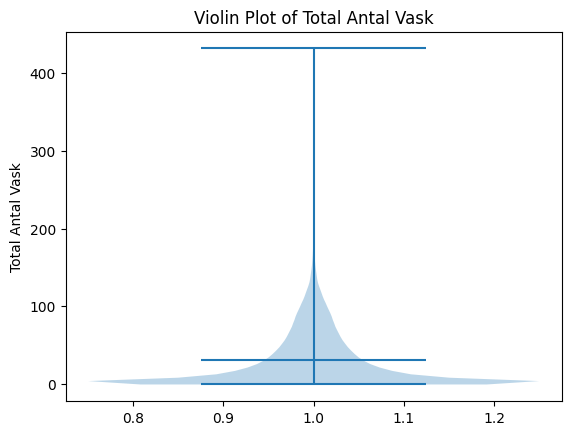

In [ ]:
# Lav et violin plot af total_antal_vask
total_antal_vask = samlet_df['Total antal vask']
plt.violinplot(total_antal_vask, showmeans=True)
plt.title('Violin Plot of Total Antal Vask')
plt.ylabel('Total Antal Vask')
plt.show()

## Opdeling i produktgruppe

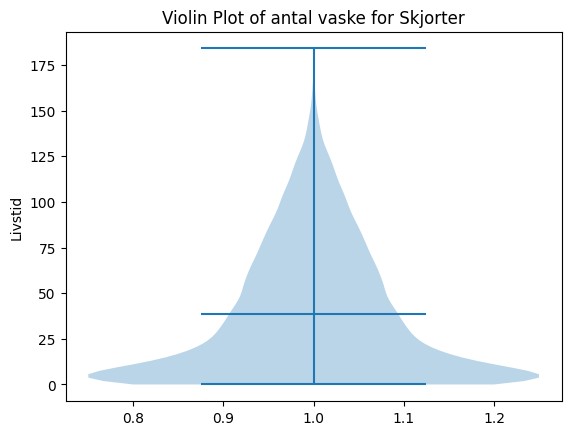

In [ ]:
# Find alle tildfælde hvor skjorte indgår i produktnavnet
skjorte_data = samlet_df[samlet_df['Produkt - Produkt'].str.contains('skjorte', case=False, na=False)]

antal_vaske = skjorte_data['Total antal vask']
plt.violinplot(antal_vaske, showmeans=True)
plt.title('Violin Plot of antal vaske for Skjorter')
plt.ylabel('Livstid')
plt.show()

## Opdeling af gruppe og kasseringsårsag

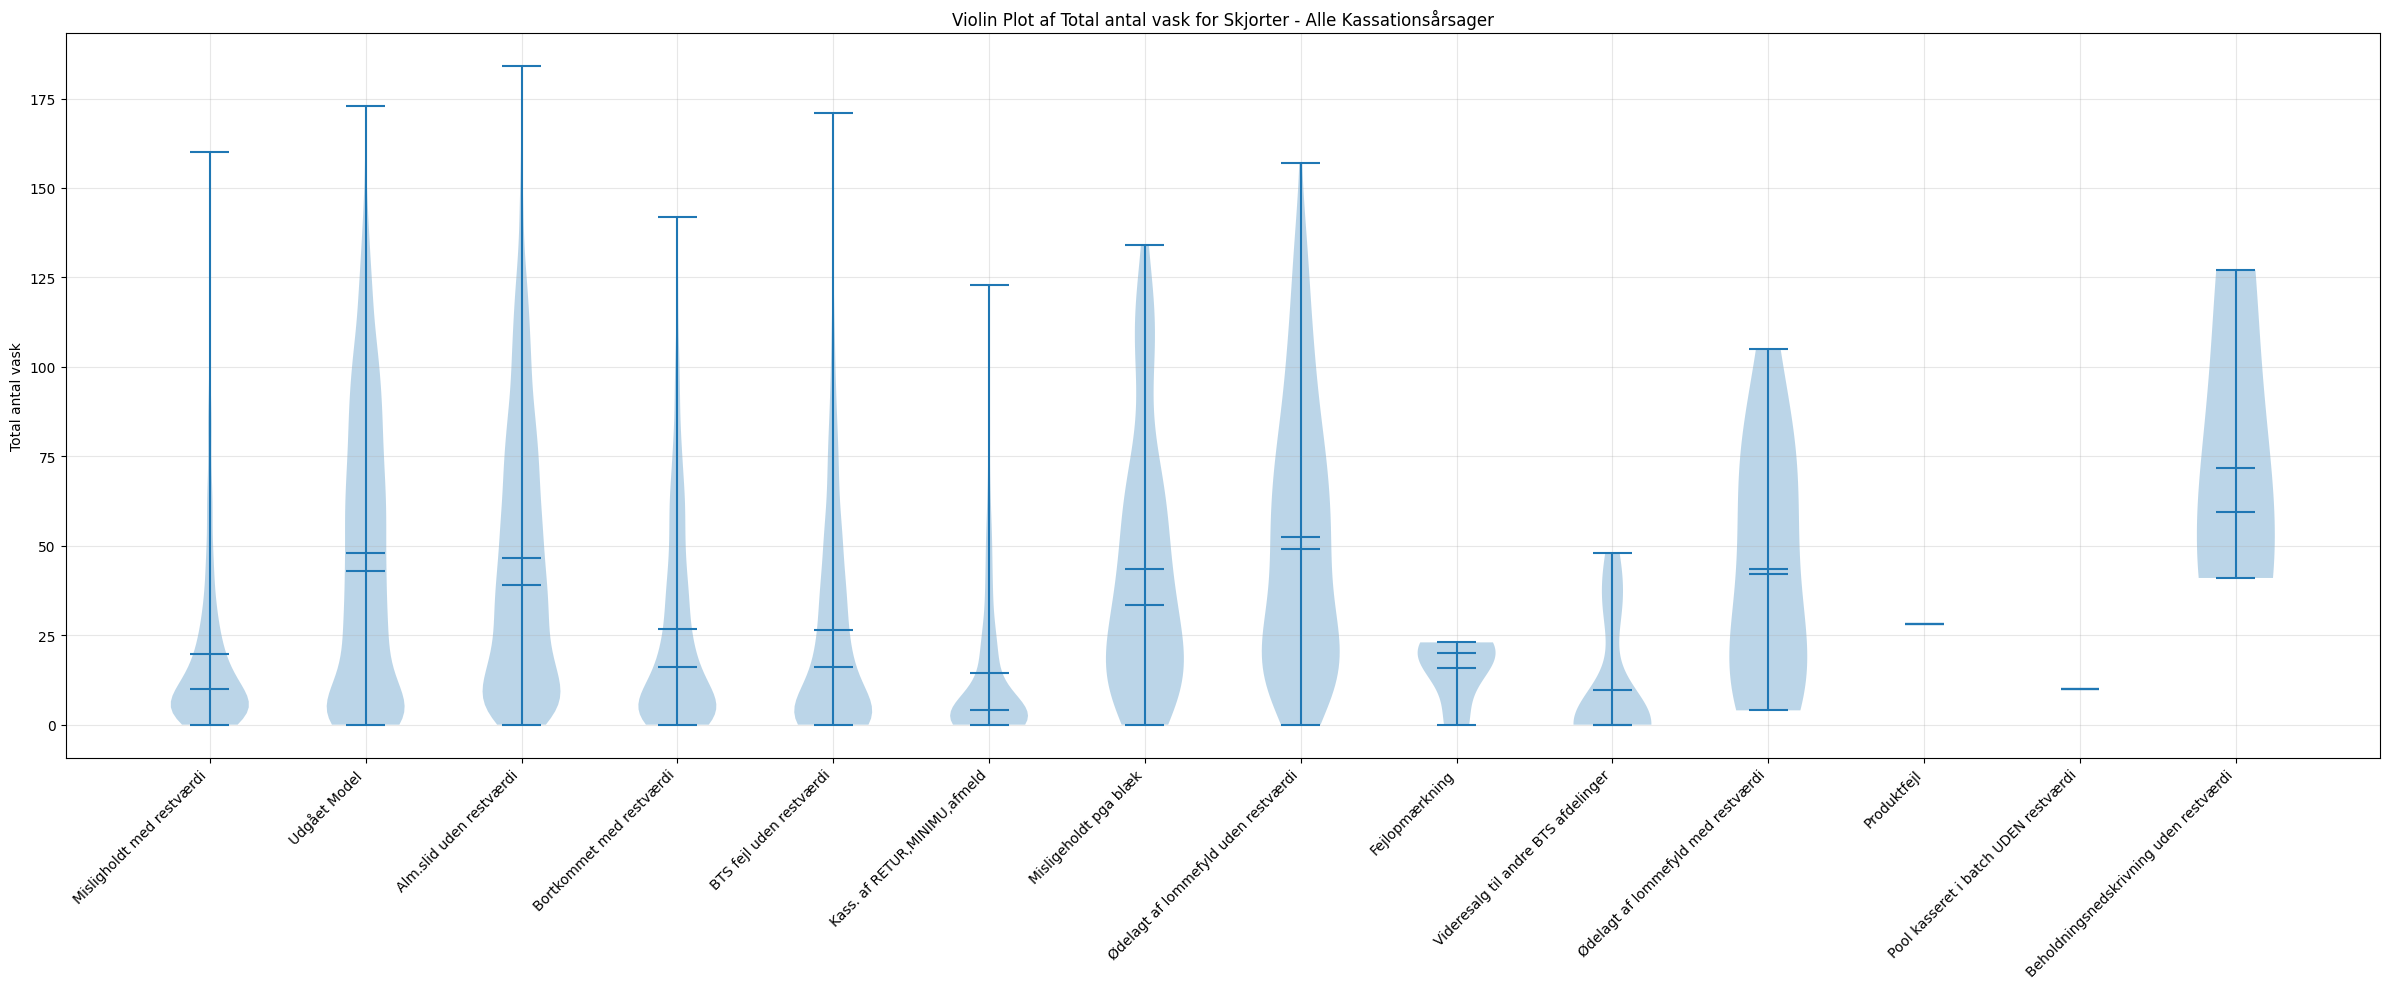

In [ ]:
# Lav violin plot for hver kassationsårsag for skjorter i én figur
kassationsårsager = skjorte_data['Kassationsårsag (ui)'].unique()

# Forbered data for alle årsager
data_list = []
labels = []
for årsag in kassationsårsager:
    data = skjorte_data[skjorte_data['Kassationsårsag (ui)'] == årsag]['Total antal vask']
    if len(data) > 0:  # Kun inkluder hvis der er data
        data_list.append(data)
        labels.append(årsag)

# Opret figur
fig, ax = plt.subplots(figsize=(24, 10))

# Lav violin plots
parts = ax.violinplot(data_list, showmeans=True, showmedians=True)

# Tilpas udseende
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Total antal vask')
ax.set_title('Violin Plot af Total antal vask for Skjorter - Alle Kassationsårsager')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Antal vaske pr. kassationsårsag

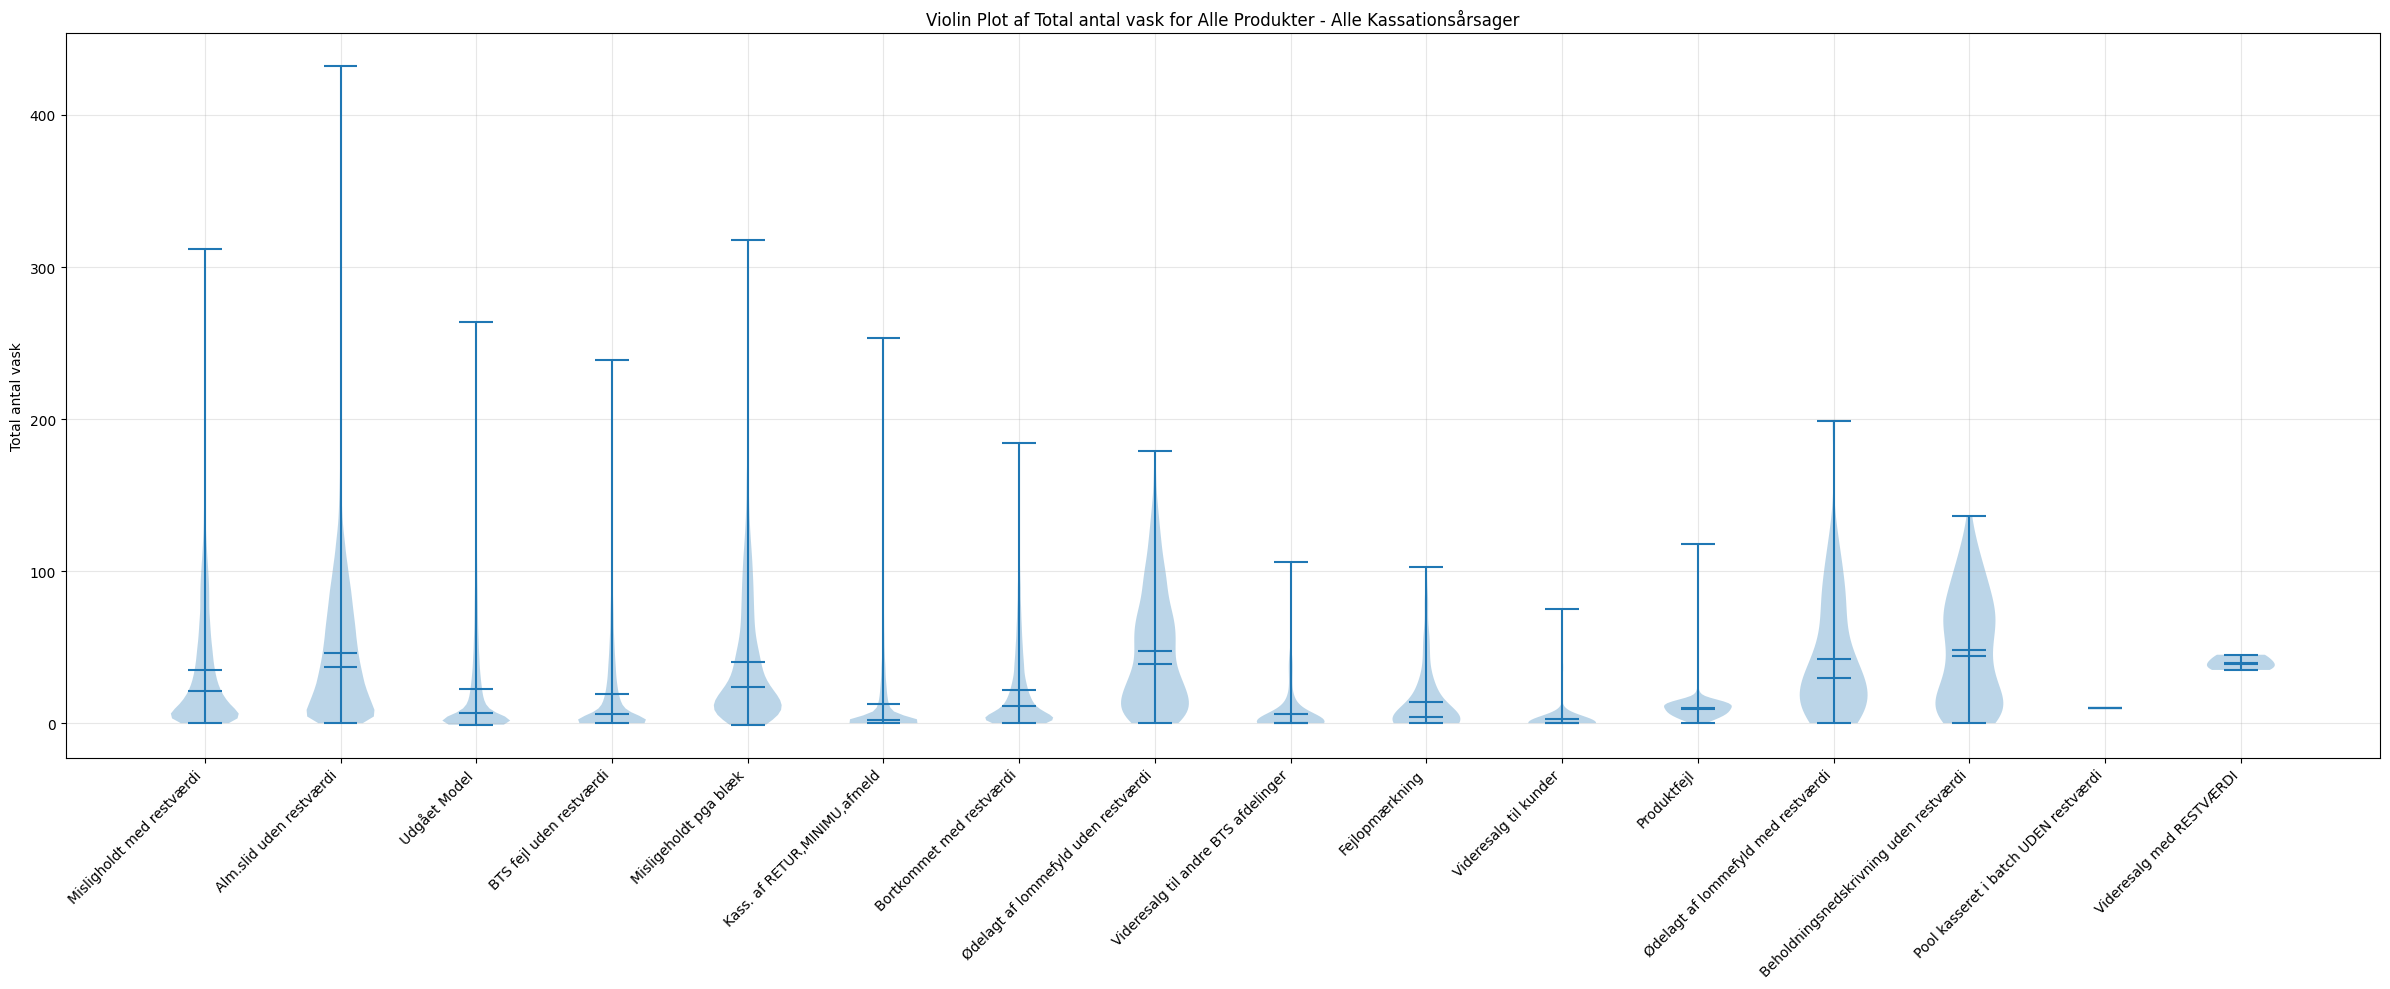

In [ ]:
kassationsårsager = samlet_df['Kassationsårsag (ui)'].unique()

# Lav violin plot for antal vaske for alle produkter oghver kassationsårsag i én figur
data_list = []
labels = []
for årsag in kassationsårsager:
    data = samlet_df[samlet_df['Kassationsårsag (ui)'] == årsag]['Total antal vask']
    if len(data) > 0:  # Kun inkluder hvis der er data
        data_list.append(data)
        labels.append(årsag)
# Opret figur
fig, ax = plt.subplots(figsize=(24, 10))
# Lav violin plots
parts = ax.violinplot(data_list, showmeans=True, showmedians=True)
# Tilpas udseende
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Total antal vask')
ax.set_title('Violin Plot af Total antal vask for Alle Produkter - Alle Kassationsårsager')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()